# We are going to compare two Deep Learning AutoML libraries on the classic Titanic classification dataset.
## The first AutoML library we will try is Autokeras. You can see their web site here:
https://autokeras.com/
## Autokeras was developed by DATA Lab at Texas A&M University. It has 1000's of stars on Github and maintained by an army of programmers.

## The next AutoML library we will try is: Deep AutoViML.
<img src="https://github.com/AutoViML/deep_autoviml/raw/master/logo.jpg" alt="banner"/>

## Deep AV is a brand new library and is built from the ground-up using the latest in Tensorflow and Keras technology. It uses keras preprocessing layers which just came out and is based on Tensorflow 2.5.

We will use the same test-train split in both using the same random_states and everything. Only thing is we will test on the final heldout test.

# If you want to see more on German Credit, you can see another great notebook by Marilia here:

https://www.kaggle.com/mpwolke/creditability-deep-autoviml

In [ ]:
!pip install git+https://github.com/AutoViML/deep_autoviml.git

In [ ]:
from deep_autoviml import deep_autoviml as deepauto

In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git

In [ ]:
!pip install autokeras

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import autokeras as ak

# Please make sure you install deep_autoviml first and then auto-keras.
Otherwise the next few steps will give errors

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
TRAIN_DATA_URL = '/kaggle/input/titanic/train.csv'
TEST_DATA_URL = '/kaggle/input/titanic/test.csv'

In [ ]:
df=pd.read_csv(TRAIN_DATA_URL,encoding ='ISO-8859-1',sep=",")
print(df.shape)
df.head()

In [ ]:
### we find that the Cabin feature can be broken up into two parts: alpha and numeric
df['Cabin1'] = df['Cabin'].fillna('Missing').map(lambda x: x[:1])
df['Cabin2'] = df['Cabin'].fillna('Missing').map(lambda x: x[1:])
df.drop('Cabin',axis=1, inplace=True)
df.head(2)

In [ ]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    overwrite=True, max_trials=5)

In [ ]:
### we are going to drop PassengerID from consideration since it's an ID variable
preds = df.columns[2:].tolist()
targets = df.columns[:2].tolist()
target = targets[1]
target

In [ ]:
x=df[preds].to_numpy()
x[:2]

In [ ]:
y = df[[target]].to_numpy()
y[:2]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size= 0.20, random_state= True,stratify=y) 
x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [ ]:
y_train=y_train.reshape((-1))
y_train.shape

In [ ]:
y_test=y_test.reshape((-1))
y_test.shape

In [ ]:
clf.fit(x_train, y_train, epochs=5)

# In autokeras, you can set number of epochs to run and max-trials. We set them quite low but got pretty good results on validation. The validation accuracy is 75% - this is a decent number but not great. Let's test results on x-test dataset


In [ ]:
# Predict with the best model.
predicted_y = clf.predict(x_test).ravel()
predicted_y[:4]

In [ ]:
y_test[:4]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy = %0.0f%%' %(100*accuracy_score(y_test, predicted_y)))
print('Confusion Matrix: \n%s' %confusion_matrix(y_test, predicted_y))
print('Classification Report: \n%s' %classification_report(y_test, predicted_y))

## The results on test set are pretty good. with 80-82% accuracy
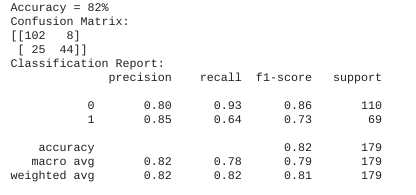

## We can see that autokeras provides very good results. Now let's try another AutoML library called Deep AutoViML

# Let us now compare the results to Deep_AutoViML which has the following features:
1. You don't have to clean your data. You can feed it as it is.
2. You don't have to preprocess text or categorical or string / NLP columns. It will handle preprocessing automatically.
3. The best part is, your model comes with the preprocessing steps as keras layers. So you can immediately deploy the model and predict on raw test data without any preprocessing steps since the model will do that automatically

In [ ]:
df.head(1)

In [ ]:
train = pd.DataFrame(np.c_[x_train,y_train], index=range(len(x_train)), columns = preds+[target])
test = pd.DataFrame(np.c_[x_test,y_test], index=range(len(x_test)), columns = preds+[target])
print(train.shape, test.shape)
train.head(2)

In [ ]:
################################################################################
keras_model_type =  "auto" ## always try "fast", then "fast1", "fast2" and "auto"
### always set early_stopping to True first and then change it to False
#### You always need 15 max_trials to get something decent #####
keras_options = {"early_stopping": True, 'lr_scheduler': ''}  
#### always set tuner to "storm" and then "optuna". 
# NLP char limit kicks off NLP processing. Feature Cross later.
model_options = {'tuner':"storm", "max_trials": 5, 'nlp_char_limit':10,
                 'cat_feat_cross_flag':False, }
project_name = 'Titanic' ### this is the folder where the model will be saved
################################################################################

In [ ]:
model, cat_vocab_dict = deepauto.fit(train, target, keras_model_type=keras_model_type,
		project_name=project_name, keras_options=keras_options,  
		model_options=model_options, save_model_flag=True, use_my_model='',
		model_use_case='', verbose=0)

# You can see that overall accuracy is 83% which is the same as autokeras accuracy which had 80-82%. 
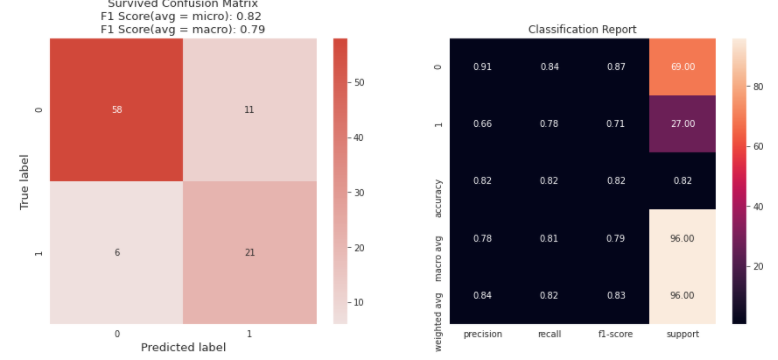

# But this is where you get an extra bonus: AutoViML provides a much more customized model with preprocessing layers suited to Titanic in a Deep Learning setting so that you can deploy this best model.
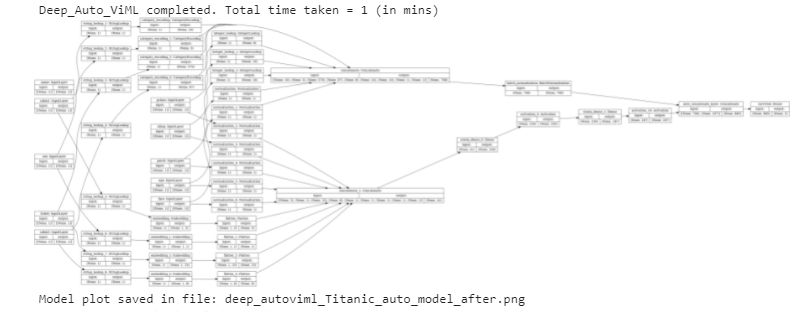

In [ ]:
predictions = deepauto.predict(model, project_name, test_dataset=test,
                                 keras_model_type=keras_model_type, 
                                 cat_vocab_dict=cat_vocab_dict)

In [ ]:
y_test = test[target].astype(int).values
y_test[:4]

In [ ]:
y_preds = predictions[-1]
y_preds[:4]

## We will now test the model on the heldout test dataset. 
We can see that accuracy drops a bit since the dataset is too small and model probably overfit on such a small dataset. However, we can try other keras_model_type="fast1", "fast2" etc and see whether we can get better results

In [ ]:
from deep_autoviml import print_classification_model_stats
from sklearn.metrics import accuracy_score
print('Accuracy = %0.0f%%' %(100*accuracy_score(y_test, y_preds)))
print_classification_model_stats(y_test, y_preds)

## The results on test set are better than Autokeras with 80% accuracy on Deep_AutoViML
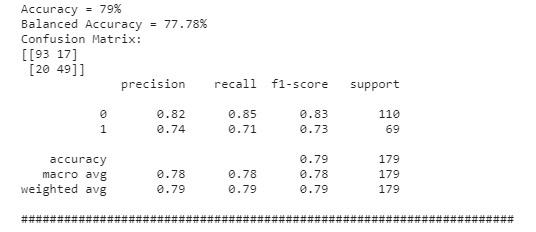

# So deep_autoviml has the same or better performance in less than 1 minute on Titanic Data Set. But the biggest advantages of deep_autoviml are the following:
1. The important advantage of using deep_autoviml is that you don't have to clean your data. You can feed it as it is.
2. You don't have to preprocess text or categorical or string / NLP columns. It will handle preprocessing automatically.
3. The best part is, your model comes with the preprocessing steps as keras layers. So you can immediately deploy the model and predict on raw test data without any preprocessing steps since the model will do that automatically

# Hope this notebook was helpful. If you liked it, pelase upvote it

Please see more notebooks by my friend Marilia Prata for deep_autoviml:

Deep_AutoViML on German Credit Data:
https://www.kaggle.com/mpwolke/creditability-deep-autoviml

